In [2]:
#Mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
STOPWORDS = set(stopwords.words('english'))

In [5]:
df=pd.read_csv("/gdrive/MyDrive/Newsgroup-bbc/bbc-text.csv")
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [6]:
df.describe()


,category,text
count,2225,2225
unique,5,2126
top,sport,talks aim to avert pension strike talks aimed ...
freq,511,2


In [7]:
df['category'].nunique()


5

In [8]:
df['category'].value_counts()


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


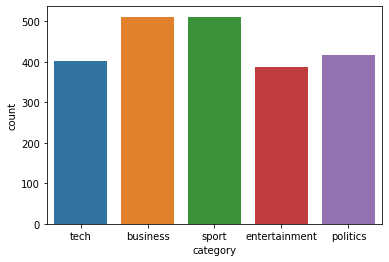

In [9]:
sns.countplot(df['category'])

In [10]:
df['text'][10]

'berlin cheers for anti-nazi film a german movie about an anti-nazi resistance heroine has drawn loud applause at berlin film festival.  sophie scholl - the final days portrays the final days of the member of the white rose movement. scholl  21  was arrested and beheaded with her brother  hans  in 1943 for distributing leaflets condemning the  abhorrent tyranny  of adolf hitler. director marc rothemund said:  i have a feeling of responsibility to keep the legacy of the scholls going.   we must somehow keep their ideas alive   he added.  the film drew on transcripts of gestapo interrogations and scholl s trial preserved in the archive of communist east germany s secret police. their discovery was the inspiration behind the film for rothemund  who worked closely with surviving relatives  including one of scholl s sisters  to ensure historical accuracy on the film. scholl and other members of the white rose resistance group first started distributing anti-nazi leaflets in the summer of 19

In [11]:
df.isnull().sum()


category    0
text        0
dtype: int64

In [12]:
space = re.compile('[/(){}\[\]\|@,;]')
symbols= re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = symbols.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [13]:
df['text']=df['text'].apply(clean_text)


In [14]:
df['text'][10]


'berlin cheers antinazi film german movie antinazi resistance heroine drawn loud applause berlin film festival sophie scholl final days portrays final days member white rose movement scholl 21 arrested beheaded brother hans 1943 distributing leaflets condemning abhorrent tyranny adolf hitler director marc rothemund said feeling responsibility keep legacy scholls going must somehow keep ideas alive added film drew transcripts gestapo interrogations scholl trial preserved archive communist east germany secret police discovery inspiration behind film rothemund worked closely surviving relatives including one scholl sisters ensure historical accuracy film scholl members white rose resistance group first started distributing antinazi leaflets summer 1942 arrested dropped leaflets munich university calling day reckoning adolf hitler regime film focuses si days scholl arrest intense trial saw scholl initially deny charges ended defiant appearance one three german films vying top prize festiva

In [15]:
df['text'][50]


'lewsey puzzle disallowed try england josh lewsey claimed denied late try side si nations loss ireland wasps wing insisted grounded ball bundled line said referee jonathan kaplan made wrong decision positive touched ball line lewsey told bbc sport certainly turnover driven put ball ground whistle went let go ball lewsey added one irish players scooped back whistle surprise referee gave turnover far concerned incident mark cueto effort charlie hodgson crossfield kick led looked like good try two key elements game cueto also puzzled try disallowed kaplan think could offside without doubt behind ball said sale player move planned technique cuff rehearse time time say robbed decisions go go today went us tough international level'

In [16]:
g=[]


In [17]:
for i in df['text']:
    g.append(i)

In [18]:
len(g)


2225

In [19]:
len(g[4])


1207

In [20]:
maxl = max([len(s) for s in g])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 16201


In [21]:
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 32485 unique tokens.


In [22]:
maxl


16201

In [23]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=3000)

In [24]:
X.shape


(2225, 3000)

In [25]:
Y = pd.get_dummies(df['category'],columns=df["category"]).values
Y


array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [26]:
len(Y)


2225

In [27]:
Y[0]


array([0, 0, 0, 0, 1], dtype=uint8)

In [28]:
# 1 Label - Business
# 2 Label - Entertainment
# 3 Label - Politics
# 4 Label - Sport
# 5 Label - Tech

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2002, 3000) (2002, 5)
(223, 3000) (223, 5)


In [30]:
#MODEL

model=Sequential()
model.add(Embedding(50000,100,input_length=3000))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 3000, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_train, Y_train, epochs=7, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/7
29/29 [==============================] - 611s 21s/step - loss: 1.5892 - accuracy: 0.2865 - val_loss: 1.5070 - val_accuracy: 0.4975
Epoch 2/7
29/29 [==============================] - 604s 21s/step - loss: 1.2618 - accuracy: 0.5458 - val_loss: 1.0802 - val_accuracy: 0.6269
Epoch 3/7
29/29 [==============================] - 597s 21s/step - loss: 0.8232 - accuracy: 0.7773 - val_loss: 0.4965 - val_accuracy: 0.8159
Epoch 4/7
29/29 [==============================] - 586s 20s/step - loss: 0.3431 - accuracy: 0.9178 - val_loss: 0.5913 - val_accuracy: 0.8756
Epoch 5/7
29/29 [==============================] - 596s 21s/step - loss: 0.2243 - accuracy: 0.9606 - val_loss: 0.2361 - val_accuracy: 0.9453
Epoch 6/7
29/29 [==============================] - 614s 21s/step - loss: 0.0615 - accuracy: 0.9872 - val_loss: 0.1622 - val_accuracy: 0.9502
Epoch 7/7
29/29 [==============================] - 605s 21s/step - loss: 0.0258 - accuracy: 0.9961 - val_loss: 0.2643 - val_accuracy: 0.9353


In [36]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


7/7 [==============================] - 7s 979ms/step - loss: 0.2920 - accuracy: 0.9238
Test set
  Loss: 0.292
  Accuracy: 0.924


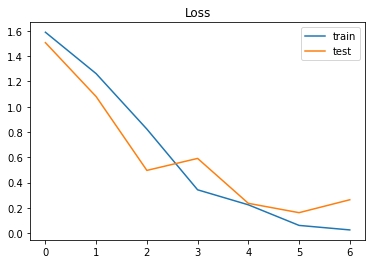

In [34]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

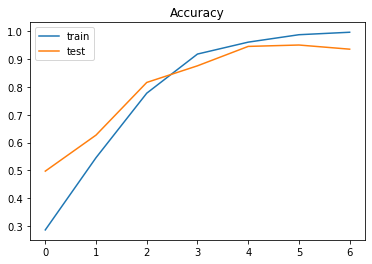

In [37]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();